In [14]:
# #!/bin/bash
# !curl -L -o ~/datasets/amazon-books-reviews.zip\
#   https://www.kaggle.com/api/v1/datasets/download/mohamedbakhet/amazon-books-reviews

# !pip install pandas 
# !which python

# Discover book data

In [15]:
import pandas as pd
import os

# Use raw string (r) or forward slashes for Windows paths
dir_path = r"C:\Users\Admin\Documents\GitHub\Two-stages-recommendation-system\datasets\extracted"


# Construct full file path safely
file_path_rating = os.path.join(dir_path, 'Books_rating.csv')

# Load the data (add error handling)
try:
    df = pd.read_csv(file_path_rating)
    print("Data loaded successfully!")
    
    # Basic info
    print("\nData Info:")
    print(df.info())
    
    # Show first 3 rows
    print("\nFirst 3 rows:")
    print(df.head(3))
    
    # Basic statistics
    print("\nBasic Statistics:")
    print(df.describe(include='all'))
    
except FileNotFoundError:
    print(f"Error: File not found at {file_path_rating}")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Data loaded successfully!

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB
None

First 3 rows:
           Id                           Title  Price         User_id  \
0  1882931173  Its Only Art If Its Well Hung!    NaN   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon    NaN  A30TK6U7DNS82R   
2  0826414346        Dr. Seuss: American Icon    NaN  A3UH4UZ4RSVO82   

             profileName review/helpfulness  review/score  review/time  \
0  Jim

# Preprocess for cadidate_generation stage

#### 1. Keep Only Required Columns

In [16]:
df = df[['User_id', 'Id', 'review/score']]
df.head()


,User_id,Id,review/score
0,AVCGYZL8FQQTD,1882931173,4.0
1,A30TK6U7DNS82R,0826414346,5.0
2,A3UH4UZ4RSVO82,0826414346,5.0
3,A2MVUWT453QH61,0826414346,4.0
4,A22X4XUPKF66MR,0826414346,4.0


In [20]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode users and items to numeric IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['user_idx'] = user_encoder.fit_transform(df['User_id'])
df['item_idx'] = item_encoder.fit_transform(df['Id'])

# Step 2: Build sparse matrix
sparse_matrix = csr_matrix(
    (df['review/score'], (df['user_idx'], df['item_idx']))
)

print(f"Sparse matrix shape: {sparse_matrix.shape}")
print(f"Non-zero entries: {sparse_matrix.nnz}")


Sparse matrix shape: (1008973, 221998)
Non-zero entries: 2478433


#### 2. Check some case in spare-matrix

In [26]:
user_id = "AVCGYZL8FQQTD" 
item_id = "1882931173" 

try:
    user_idx = user_encoder.transform([user_id])[0]
    item_idx = item_encoder.transform([item_id])[0]
except ValueError:
    print("User or item not found in training data.")

# Fetch rating (will be 0.0 if not rated)
rating = sparse_matrix[user_idx, item_idx]

if rating != 0.0:
    print(f"User {user_id} has rated item {item_id} with score {rating}.")
else:
    print(f"User {user_id} has NOT rated item {item_id}.")


User AVCGYZL8FQQTD has rated item 1882931173 with score 4.0.


#### 3. Save the Sparse Matrix

In [ ]:
import os
import pickle

# Ensure the output directory exists
output_dir = 'datasets/processed'
os.makedirs(output_dir, exist_ok=True)

# Save the matrix and encoders
with open(os.path.join(output_dir, 'user_item_sparse_matrix.pkl'), 'wb') as f:
    pickle.dump({
        'matrix': sparse_matrix,
        'user_encoder': user_encoder,
        'item_encoder': item_encoder
    }, f)

print("Sparse matrix and encoders saved.")


FileNotFoundError: [Errno 2] No such file or directory: 'datasets/processed/user_item_sparse_matrix.pkl'

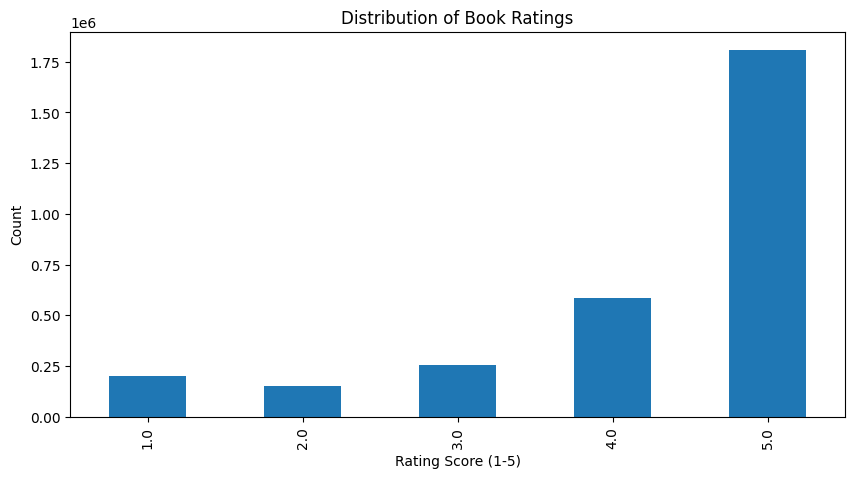

In [21]:
import matplotlib.pyplot as plt

# Rating distribution
rating_counts = df['review/score'].value_counts().sort_index()
rating_counts.plot(kind='bar', figsize=(10,5))
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating Score (1-5)')
plt.ylabel('Count')
plt.show()

In [22]:
# Review length analysis
df['review_length'] = df['review/text'].str.len()

print("\nReview length statistics:")
print(df['review_length'].describe())

# Plot review length distribution
plt.figure(figsize=(10,5))
df['review_length'].plot(kind='hist', bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Character Count')
plt.show()

KeyError: 'review/text'

In [ ]:
# Top 10 most reviewed books
top_books = df['Title'].value_counts().head(10)
print("\nTop 10 most reviewed books:")
print(top_books)

# Top 10 highest rated books (with minimum 100 reviews)
min_reviews = 100
book_stats = df.groupby('Title').agg({
    'review/score': ['mean', 'count']
}).sort_values(('review/score', 'mean'), ascending=False)
top_rated = book_stats[book_stats[('review/score', 'count')] >= min_reviews].head(10)
print("\nTop 10 highest rated books (min 100 reviews):")
print(top_rated)


Top 10 most reviewed books:
Title
The Hobbit                               22023
Pride and Prejudice                      20371
Atlas Shrugged                           12513
Wuthering Heights                        10780
The Giver                                 7644
Great Expectations                        7421
Harry Potter and The Sorcerer's Stone     6796
Of Mice and Men                           6728
Brave New World                           6312
Mere Christianity                         6053
Name: count, dtype: int64

Top 10 highest rated books (min 100 reviews):
                                                   review/score      
                                                           mean count
Title                                                                
Lilla Belle: The First Stages                          5.000000   113
Why revival tarries                                    4.970732   205
shadow castle                                          4.948276   116
Sh

In [ ]:
!pip install transformers

  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached charset_normalizer-3.4.2-cp311-cp311-win_amd64.whl.metadata (36 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/10.5 MB 6.1 MB/s eta 0:00:02
   ---------- ----------------------------- 2.6/10.5 MB 6.0 MB/s eta 0:00:02
   -------------- ------------------------- 3.7/10.5 MB 5.6 MB/s eta 0:00:02
   -------------------- ------------------- 5.2/10.5 MB 5.9 MB/s eta 0:00:01
 

In [ ]:
from transformers import pipeline


c:\Users\Admin\Documents\GitHub\Two-stages-recommendation-system\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
classifier = pipeline("text-classification", model = "bhadresh-savani/distilbert-base-uncased-emotion")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')  


Device set to use cuda:0


In [ ]:
prediction = classifier("today i'm sad")
for key, value in prediction[0].items():
    print(f"{key}: {value}")


label: sadness
score: 0.9983229041099548


In [ ]:
from transformers import pipeline

# Initialize emotion classifier
emotion_classifier = pipeline(
    "text-classification",
    model="bhadresh-savani/distilbert-base-uncased-emotion",
    truncation=True  # Automatically handles long texts
)

def detect_emotion(text):
    try:
        result = emotion_classifier(text[:1000])[0]  # Safely truncate
        return result['label']
    except:
        return "unknown"

# Apply to dataframe (first 1000 rows for testing)
df['emotion'] = df['review/text'].head(1000).apply(detect_emotion)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
df[['review/text', 'emotion']].head(30)

,review/text,emotion
0,This is only for Julie Strain fans. It's a col...,joy
1,I don't care much for Dr. Seuss but after read...,joy
2,"If people become the books they read and if ""t...",joy
3,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",joy
4,Philip Nel - Dr. Seuss: American IconThis is b...,joy
5,"""Dr. Seuss: American Icon"" by Philip Nel is a ...",joy
6,Theodor Seuss Giesel was best known as 'Dr. Se...,joy
7,When I recieved this book as a gift for Christ...,joy
8,Trams (or any public transport) are not usuall...,joy
9,"As far as I am aware, this is the first book-l...",joy


In [ ]:
df.info

<bound method DataFrame.info of                  Id                           Title  Price         User_id  \
0        1882931173  Its Only Art If Its Well Hung!    NaN   AVCGYZL8FQQTD   
1        0826414346        Dr. Seuss: American Icon    NaN  A30TK6U7DNS82R   
2        0826414346        Dr. Seuss: American Icon    NaN  A3UH4UZ4RSVO82   
3        0826414346        Dr. Seuss: American Icon    NaN  A2MVUWT453QH61   
4        0826414346        Dr. Seuss: American Icon    NaN  A22X4XUPKF66MR   
...             ...                             ...    ...             ...   
2999995  B000NSLVCU             The Idea of History    NaN             NaN   
2999996  B000NSLVCU             The Idea of History    NaN  A1SMUB9ASL5L9Y   
2999997  B000NSLVCU             The Idea of History    NaN  A2AQMEKZKK5EE4   
2999998  B000NSLVCU             The Idea of History    NaN  A18SQGYBKS852K   
2999999  B000NSLVCU             The Idea of History    NaN             NaN   

                               